In [4]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
#import rpy2.rinterface_lib.callbacks
import logging
#import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.0


In [6]:
import os              
os.environ['PYTHONHASHSEED'] = '0'
import desc
#import keras
import tensorflow as tf
from time import time                                                       
import sys

### Import dataset APE_pos e APE_neg

In [56]:
APE_pos = sc.read_10x_mtx("/home/spuccio/homeserver2/SP018_Pelosi/Lib_APE-POS/outs/filtered_feature_bc_matrix",var_names='gene_symbols',make_unique=True,)

In [57]:
APE_pos.obs['dataset'] = "APE_pos"

In [58]:
APE_neg = sc.read_10x_mtx("/home/spuccio/homeserver2/SP018_Pelosi/Lib_APE-NEG/outs/filtered_feature_bc_matrix",var_names='gene_symbols',make_unique=True,)

In [59]:
APE_neg.obs['dataset'] = "APE_neg"

In [111]:
adata = APE_pos.concatenate(APE_neg,join="outer",index_unique='-')

### Quality control

In [112]:
sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

In [113]:
adata.shape

(7976, 33538)

In [114]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [115]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [116]:
adata.var['rb'] = adata.var_names.str.startswith('RP')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

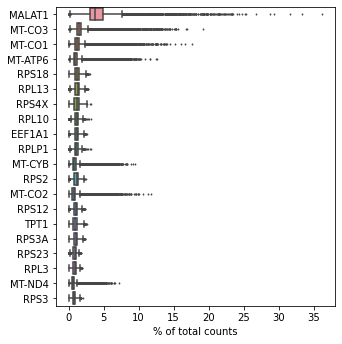

In [117]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [118]:
print("Cell x Genes before filtering")
print(adata.n_obs, adata.n_vars)

Cell x Genes before filtering
7976 33538


... storing 'dataset' as categorical
... storing 'feature_types' as categorical


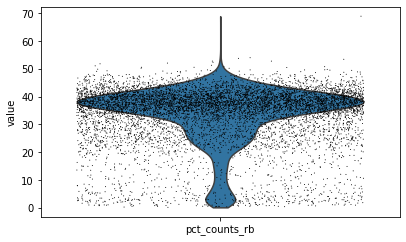

In [119]:
sc.pl.violin(adata, ['pct_counts_rb'],jitter=0.4)

In [120]:
adata = adata[adata.obs.pct_counts_rb < 45, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high ribosomial
7662 33538


In [121]:
adata = adata[adata.obs.pct_counts_rb > 10, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high ribosomial
7215 33538


In [122]:
#sc.pl.violin(adata, ['pct_counts_mt'],jitter=0.4)

In [123]:
adata = adata[adata.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high mithocondrial
6725 33538


In [124]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [125]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [133]:
#annot.to_csv("/home/spuccio/gene.csv",sep="\t",header=True,index=True) 

In [134]:
#pd.DataFrame(adata.var_names).to_csv("/home/spuccio/gene_adata.csv",sep="\t",header=True,index=True) 

In [135]:
#pd.DataFrame(adata.var_names).loc[adata.var_names == "EID2B"]

In [136]:
annot = pd.merge(pd.DataFrame(adata.var_names),annot,left_on=0,right_on="external_gene_name",how="left")

In [137]:
annot= annot.drop_duplicates([0])
annot = annot.fillna("Not_available")

In [139]:
len(annot[0].loc[(annot['gene_biotype']=="protein_coding") | (annot['gene_biotype']=="miRNA")])

19400

In [140]:
adata.var['gene_biotype'] = annot.set_index(0)['gene_biotype']
protein_coding = annot[0].loc[(annot['gene_biotype']=="protein_coding") | (annot['gene_biotype']=="miRNA")].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata.var_names, protein_coding)
adata = adata[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [141]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)
adata = adata[:, ~mito_gene_indicator]

In [142]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

6725 19387
6725 19286


In [143]:
adata.raw = adata

### Normalization

In [144]:
adata2 = adata.copy()
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)

In [145]:
adata2

AnnData object with n_obs × n_vars = 6725 × 19286
    obs: 'dataset', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'
    uns: 'log1p'

In [146]:
adata2=desc.scale_bygroup(adata2,"dataset")

In [148]:
save_dir="/home/spuccio/homeserver2/SP018_Pelosi/Temp"
adata2=desc.train(adata2,
        dims=[adata2.shape[1],64,32],
        tol=0.005,
        n_neighbors=10,
        batch_size=256,
        louvain_resolution=[0.4,0.5,0.6,0.7,0.8],# not necessarily a list, you can only set one value, like, louvain_resolution=1.0
        save_dir=str(save_dir),
        do_tsne=False,
        learning_rate=200, # the parameter of tsne
        use_GPU=False,
        num_Cores=12, #for reproducible, only use 1 cpu
        num_Cores_tsne=4,
        save_encoder_weights=False,
        save_encoder_step=3,# save_encoder_weights is False, this parameter is not used
        use_ae_weights=False,
        do_umap=True)

Start to process resolution= 0.4
The number of cpu in your computer is 32
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
use_ae_weights=False, the program will rerun autoencoder
Pretraining the 1th layer...
learning rate = 0.1
Train on 6725 samples
Epoch 1/50
6725/6725 [==============================] - 2s 285us/sample - loss: 0.4982
Epoch 2/50
6725/6725 [==============================] - 1s 196us/sample - loss: 0.4979
Epoch 3/50
6725/6725 [==============================] - 1s 194us/sample - loss: 0.4975
Epoch 4/50
6725/6725 [==============================] - 1s 191us/sample - loss: 0.4972
Epoch 5/50
6725/6725 [==============================] - 1s 191us/sample - loss: 0.4970
Epoch 6/50
6725/6725 [==============================] - 1s 185us/sample - loss: 0.4967
Epoch 7/50
6725/6725 [==============================] - 1s 186us/sample - loss: 0.4966
Epoch 8/50
6725/6725 [==============================] - 1s 218us/sample - loss: 0.4964
Epoch 9/50
6725/

In [149]:
adata2

AnnData object with n_obs × n_vars = 6725 × 19286
    obs: 'dataset', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_counts', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'
    uns: 'log1p', 'umap', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.4', 'X_umap', 'X_umap0.4', 'X_Embeded_z0.5', 'X_umap0.5', 'X_Embeded_z0.6', 'X_umap0.6', 'X_Embeded_z0.7', 'X_umap0.7', 'X_Embeded_z0.8', 'X_umap0.8'
    obsp: 'distances', 'connectivities'

In [150]:
adata.write("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Desc.h5ad")
adata2.write("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/No_Desc.h5ad")

... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
